In [1]:
import json
from tqdm import tqdm
from pathlib import Path
from utils import *
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Default paths
ROOT = Path("Amazon_products")
TRAIN_PATH = ROOT / "train"
TEST_PATH = ROOT / "test"

TRAIN_CORPUS_PATH = TRAIN_PATH / "train_corpus.txt"
TEST_CORPUS_PATH = TEST_PATH  / "test_corpus.txt"
CLASSES_PATH = ROOT / "classes.txt"
HIERARCHY_PATH = ROOT / "class_hierarchy.txt"
REL_KEYWORDS_PATH = ROOT / "class_related_keywords.txt"

In [5]:
# ---------- Read-only loads ----------

train_pid2text    = load_pid2text(TRAIN_CORPUS_PATH)
test_pid2text     = load_pid2text(TEST_CORPUS_PATH)
classes_int       = load_classes_int(CLASSES_PATH)
classes_str       = load_classes_str(CLASSES_PATH)
rel_keywords      = load_keywords(REL_KEYWORDS_PATH)
class_graph_edges = load_class_graph(HIERARCHY_PATH)

print(f"#train={len(train_pid2text):,}  #test={len(test_pid2text):,}")

#train=29,487  #test=19,658


## GCN settings

In [6]:
# Making A_hat

class_num = len(classes_int) # 531

adj_matrix = [[0 for _ in range(class_num)] for __ in range(class_num)]
for a, b in class_graph_edges:
    adj_matrix[a][b] = 1
    adj_matrix[b][a] = 1

A = torch.tensor(adj_matrix, dtype=torch.float32, device=device)  # (L, L)
I = torch.eye(A.size(0), device=device)

A_tilde = A + I
deg = A_tilde.sum(dim=1).clamp(min=1e-6)  # (L,)
D_inv_sqrt = torch.diag(torch.pow(deg, -0.5))

A_hat = D_inv_sqrt @ A_tilde @ D_inv_sqrt  # (L, L)

In [ ]:
EMB_PATH = Path("Embeddings")

train_emb_dict = load_json(EMB_PATH / "train_embeddings.json")
test_emb_dict = load_json(EMB_PATH / "test_embeddings.json")
class_emb_dict = load_json(EMB_PATH / "class_embeddings.json")

In [8]:
train_emb = torch.tensor(list(train_emb_dict.values()))
test_emb = torch.tensor(list(test_emb_dict.values()))

In [ ]:
import pandas as pd

SILVER_PATH = Path("outputs") / "tf-idf-silver.csv"

silver_label = pd.read_csv(SILVER_PATH)

# Build label -> list_of_pids using actual pid values from CSV (not row indices)
label2pid = [[] for _ in range(class_num)]
for idx, row in silver_label.iterrows():
    pid = str(row["id"])                       # 실제 pid 값을 문자열로
    labels_str = str(row.get("labels", ""))
    if labels_str and labels_str.strip():
        labels = [int(x) for x in labels_str.split(",") if x.strip() != ""]
        for label in labels:
            if 0 <= label < class_num:
                label2pid[label].append(pid)

# --- aggregate embeddings per class robustly ---
import numpy as np

# get embedding size robustly
if len(train_emb_dict) == 0:
    raise RuntimeError("train_emb_dict is empty")
emb_size = len(next(iter(train_emb_dict.values())))

pid_emb = np.zeros((class_num, emb_size), dtype=np.float32)

for i in range(class_num):
    pids_for_class = label2pid[i]
    if len(pids_for_class) == 0:
        # fallback: if we have class_emb_dict for class i, use it; otherwise leave zeros
        if str(i) in class_emb_dict:
            pid_emb[i] = np.array(class_emb_dict[str(i)], dtype=np.float32)
        else:
            # keep zero vector
            continue
    else:
        acc = np.zeros((emb_size,), dtype=np.float64)
        cnt = 0
        for pid in pids_for_class:
            # train_emb_dict keys are strings — defend both str/int
            key = str(pid)
            if key in train_emb_dict:
                vec = np.array(train_emb_dict[key], dtype=np.float64)
                if vec.size == emb_size:
                    acc += vec
                    cnt += 1
            else:
                # try if row-index style numeric keys exist (rare)
                if pid.isdigit() and pid in train_emb_dict:
                    vec = np.array(train_emb_dict[pid], dtype=np.float64)
                    if vec.size == emb_size:
                        acc += vec
                        cnt += 1
        if cnt > 0:
            pid_emb[i] = (acc / cnt).astype(np.float32)
        else:
            # fallback to class_emb_dict if available
            if str(i) in class_emb_dict:
                pid_emb[i] = np.array(class_emb_dict[str(i)], dtype=np.float32)
            else:
                # remains zeros
                pass

# convert to torch tensor
pid_emb = torch.tensor(pid_emb, dtype=torch.float32, device=device)

In [10]:
class LabelGCN(nn.Module):
    """
    Multi-layer Graph Convolutional Network (GCN) encoder for label embeddings.

    Each layer should perform the following steps:
        1. Aggregate neighbor embeddings: H <- A_hat @ H
        2. Linear transformation: H <- H @ W
        3. (Optional) Apply ReLU and Dropout (skip for the last layer)

    Args:
        emb_dim (int): Dimension of label embeddings.
        num_layers (int): Number of GCN layers.
        dropout (float): Dropout probability.
    """
    def __init__(self, emb_dim, num_layers=1, dropout=0.5):
        super().__init__()

        assert num_layers >= 1

        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.weights = nn.ParameterList()

        for _ in range(num_layers):
            W = nn.Parameter(torch.empty(emb_dim, emb_dim))
            nn.init.xavier_uniform_(W)
            self.weights.append(W)

    def forward(self, H, A_hat):
        """
        Args:
            H (torch.Tensor): Initial label embeddings, shape (num_labels, emb_dim).
            A_hat (torch.Tensor): Normalized adjacency matrix, shape (num_labels, num_labels).

        Returns:
            torch.Tensor: Updated label embeddings, shape (num_labels, emb_dim).
        """

        out = H

        # for each layer:
        for l, W in enumerate(self.weights):
            out = A_hat @ out                   # (L, L) @ (L, d) -> (L, d)
            out = out @ W                       # (L, d) @ (d, d) -> (L, d)
            is_last = (l == self.num_layers - 1)

            if not is_last:
                out = F.relu(out, inplace=False)
                out = self.dropout(out)

        return out

In [11]:
label_gcn = LabelGCN(emb_dim=emb_size, num_layers=2, dropout=0.25).to(device)
class_emb = label_gcn(pid_emb, A_hat)

In [12]:
class_emb.shape

torch.Size([531, 768])

## MLP for Silver-Label Training

In [13]:
class DocDataset(Dataset):
    def __init__(self, doc_emb, label_matrix):
        """
        doc_emb: np.ndarray or torch.Tensor, shape (N, d_doc)
        label_matrix: np.ndarray or torch.Tensor, shape (N, C)  # multi-label 0/1
        """
        if isinstance(doc_emb, torch.Tensor):
            self.X = doc_emb.float()
        else:
            self.X = torch.tensor(doc_emb, dtype=torch.float32)

        if isinstance(label_matrix, torch.Tensor):
            self.y = label_matrix.float()
        else:
            self.y = torch.tensor(label_matrix, dtype=torch.float32)

        assert len(self.X) == len(self.y), "X, y 길이가 다름"

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "X": self.X[idx],  # (d_doc,)
            "y": self.y[idx],  # (C,)
        }

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

labels_list = silver_label["labels"].fillna("").apply(
    lambda s: [int(x) for x in str(s).split(",") if x != ""]
)

# 멀티레이블 0/1 행렬 생성 (N, C)
mlb = MultiLabelBinarizer(classes=list(range(531)))
Y = mlb.fit_transform(labels_list)   # shape: (N, num_labels)

# 필요하면 DataFrame으로
label_cols = [f"class_{c}" for c in range(531)]
Y_df = pd.DataFrame(Y, columns=label_cols)

silver_label_matrix = Y_df.to_numpy(dtype="float32")  # (N, C)

In [15]:
print("train_emb:", train_emb.shape)
print("silver_label_matrix:", silver_label_matrix.shape)

train_emb: torch.Size([29487, 768])
silver_label_matrix: (29487, 531)


In [30]:
dataset = DocDataset(
    doc_emb=train_emb,                 # (N, d_doc)  encode_texts 결과
    label_matrix=silver_label_matrix # (N, C)      multi-label 0/1
)

val_ratio  = 0.25

val_size   = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

g = torch.Generator().manual_seed(42)

train_split, val_split = random_split(dataset, [train_size, val_size], generator=g)

train_loader = DataLoader(train_split, batch_size=32, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_split,   batch_size=64, shuffle=False, drop_last=False)

In [31]:
class DocClassMatchingMLP(nn.Module):
    def __init__(self, doc_dim, cls_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(doc_dim + cls_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, doc_emb, class_emb):
        """
        doc_emb: (B, d_doc)
        class_emb: (C, d_cls)
        return: logits (B, C)
        """
        B, d_doc = doc_emb.size()
        C, d_cls = class_emb.size()

        # (B, 1, d_doc) -> (B, C, d_doc)
        doc_expanded = doc_emb.unsqueeze(1).expand(B, C, d_doc)
        # (1, C, d_cls) -> (B, C, d_cls)
        cls_expanded = class_emb.unsqueeze(0).expand(B, C, d_cls)

        x = torch.cat([doc_expanded, cls_expanded], dim=-1)  # (B, C, d_doc + d_cls)
        x = F.relu(self.fc1(x))                              # (B, C, hidden_dim)
        logits = self.fc2(x).squeeze(-1)                    # (B, C)

        return logits


class DualEncoderClassifier(nn.Module):
    """
    Dual-Encoder + MLP Matching 모델
    - 문서 임베딩: doc_emb_batch (B, d)
    - 클래스 임베딩: class_emb (C, d) 를 buffer로 들고 있음
    - 출력: logits (B, C)
    """
    def __init__(self, doc_dim, class_emb, hidden_dim=256):
        super().__init__()
        self.doc_dim = doc_dim
        self.cls_dim = class_emb.size(1)
        self.matcher = DocClassMatchingMLP(doc_dim, self.cls_dim, hidden_dim)

        # class_emb를 buffer로 저장 (학습 X, forward에서 사용)
        self.register_buffer("class_emb", class_emb.clone().detach())

    def forward(self, doc_emb_batch):
        """
        doc_emb_batch: (B, d_doc)
        returns: logits (B, C)
        """
        return self.matcher(doc_emb_batch, self.class_emb)


In [32]:
# class_emb: (C, d), doc_dim = class_emb.size(1)
doc_dim = class_emb.size(1)  # BERT hidden size랑 같다고 가정
model = DualEncoderClassifier(doc_dim, class_emb, hidden_dim=256).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # multi-label 용

In [33]:
from sklearn.metrics import f1_score

def evaluate(model, data_loader, device=device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            X = batch["X"].to(device)          # (B, d_doc)
            y = batch["y"].to(device)          # (B, C)
            logits = model(X)                  # (B, C)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds, dim=0)    # (N, C)
    all_labels = torch.cat(all_labels, dim=0)  # (N, C)

    # 1) 기존 exact match (subset accuracy) - 참고용
    subset_acc = (all_preds == all_labels).all(dim=1).float().mean().item()

    # 2) Jaccard / example-based accuracy (조금 더 널널한 accuracy)
    #    intersection / union 을 샘플별로 계산
    intersection = (all_preds * all_labels).sum(dim=1)                # (N,)
    union = ((all_preds + all_labels) > 0).float().sum(dim=1)         # (N,)
    union = union.clamp(min=1.0)  # 라벨이 아예 없는 경우 0으로 나눔 방지
    jaccard_acc = (intersection / union).mean().item()

    # 3) F1-macro / F1-micro (스코어는 numpy로 넘기는게 안전)
    y_true = all_labels.numpy()
    y_pred = all_preds.numpy()
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

    return {
        "subset_acc": subset_acc,      # 완전 일치율 (빡센 기준)
        "accuracy": jaccard_acc,       # 널널한 accuracy로 이걸 메인으로 보면 됨
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }


In [34]:
results_dict = {'valid':{}}

In [35]:
EPOCHS = 100

best_score = 0.0
wait_time = 10
cnt = 0
best_model_state = copy.deepcopy(model.state_dict())

train_losses, val_acc_list = [], []

for epoch in range(1, EPOCHS + 1):
    # --- Training phase ---
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)     # (B, d_doc)
        y = batch["y"].to(device)     # (B, C)  multi-label 0/1

        logits = model(X)             # (B, C)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(train_loader))
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # --- Validation evaluation ---
    val_result = evaluate(model, val_loader, device=device)
    val_acc = float(val_result.get("accuracy", 0.0))
    val_acc_list.append(val_acc)
    print_eval_result(val_result, stage="validation")
    print()

    # --- Early Stopping ---
    if val_acc > best_score:
        best_score = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        cnt = 0
    else:
        cnt += 1
        if cnt >= wait_time:
            print(f"No improvement for {cnt} epochs. Early stopping.")
            break

# --- Restore best model ---
model.load_state_dict(best_model_state)


Epoch 1: 100%|██████████| 691/691 [00:05<00:00, 120.79it/s]


[Epoch 1] Train Loss: 0.0290
[VALIDATION] Acc: 0.1096 | F1-macro: 0.0018



Epoch 2: 100%|██████████| 691/691 [00:05<00:00, 121.18it/s]


[Epoch 2] Train Loss: 0.0219
[VALIDATION] Acc: 0.2054 | F1-macro: 0.0033



Epoch 3: 100%|██████████| 691/691 [00:05<00:00, 118.67it/s]


[Epoch 3] Train Loss: 0.0206
[VALIDATION] Acc: 0.1778 | F1-macro: 0.0032



Epoch 4: 100%|██████████| 691/691 [00:05<00:00, 117.53it/s]


[Epoch 4] Train Loss: 0.0196
[VALIDATION] Acc: 0.2117 | F1-macro: 0.0039



Epoch 5: 100%|██████████| 691/691 [00:05<00:00, 115.90it/s]


[Epoch 5] Train Loss: 0.0189
[VALIDATION] Acc: 0.2355 | F1-macro: 0.0050



Epoch 6: 100%|██████████| 691/691 [00:06<00:00, 114.89it/s]


[Epoch 6] Train Loss: 0.0184
[VALIDATION] Acc: 0.2703 | F1-macro: 0.0063



Epoch 7: 100%|██████████| 691/691 [00:05<00:00, 117.03it/s]


[Epoch 7] Train Loss: 0.0180
[VALIDATION] Acc: 0.1999 | F1-macro: 0.0096



Epoch 8: 100%|██████████| 691/691 [00:06<00:00, 114.32it/s]


[Epoch 8] Train Loss: 0.0177
[VALIDATION] Acc: 0.2419 | F1-macro: 0.0109



Epoch 9: 100%|██████████| 691/691 [00:05<00:00, 116.65it/s]


[Epoch 9] Train Loss: 0.0174
[VALIDATION] Acc: 0.1907 | F1-macro: 0.0104



Epoch 10: 100%|██████████| 691/691 [00:05<00:00, 119.88it/s]


[Epoch 10] Train Loss: 0.0172
[VALIDATION] Acc: 0.3118 | F1-macro: 0.0137



Epoch 11: 100%|██████████| 691/691 [00:05<00:00, 119.21it/s]


[Epoch 11] Train Loss: 0.0170
[VALIDATION] Acc: 0.3127 | F1-macro: 0.0162



Epoch 12: 100%|██████████| 691/691 [00:05<00:00, 121.10it/s]


[Epoch 12] Train Loss: 0.0169
[VALIDATION] Acc: 0.2711 | F1-macro: 0.0148



Epoch 13: 100%|██████████| 691/691 [00:05<00:00, 120.57it/s]


[Epoch 13] Train Loss: 0.0167
[VALIDATION] Acc: 0.3298 | F1-macro: 0.0183



Epoch 14: 100%|██████████| 691/691 [00:05<00:00, 120.41it/s]


[Epoch 14] Train Loss: 0.0166
[VALIDATION] Acc: 0.2807 | F1-macro: 0.0162



Epoch 15: 100%|██████████| 691/691 [00:05<00:00, 118.89it/s]


[Epoch 15] Train Loss: 0.0164
[VALIDATION] Acc: 0.3192 | F1-macro: 0.0157



Epoch 16: 100%|██████████| 691/691 [00:05<00:00, 119.19it/s]


[Epoch 16] Train Loss: 0.0163
[VALIDATION] Acc: 0.2929 | F1-macro: 0.0188



Epoch 17: 100%|██████████| 691/691 [00:05<00:00, 116.14it/s]


[Epoch 17] Train Loss: 0.0162
[VALIDATION] Acc: 0.2672 | F1-macro: 0.0191



Epoch 18: 100%|██████████| 691/691 [00:06<00:00, 112.45it/s]


[Epoch 18] Train Loss: 0.0161
[VALIDATION] Acc: 0.2560 | F1-macro: 0.0254



Epoch 19: 100%|██████████| 691/691 [00:05<00:00, 120.61it/s]


[Epoch 19] Train Loss: 0.0160
[VALIDATION] Acc: 0.2921 | F1-macro: 0.0243



Epoch 20: 100%|██████████| 691/691 [00:05<00:00, 121.58it/s]


[Epoch 20] Train Loss: 0.0159
[VALIDATION] Acc: 0.2591 | F1-macro: 0.0230



Epoch 21: 100%|██████████| 691/691 [00:05<00:00, 122.10it/s]


[Epoch 21] Train Loss: 0.0158
[VALIDATION] Acc: 0.3116 | F1-macro: 0.0259



Epoch 22: 100%|██████████| 691/691 [00:05<00:00, 121.35it/s]


[Epoch 22] Train Loss: 0.0157
[VALIDATION] Acc: 0.3329 | F1-macro: 0.0273



Epoch 23: 100%|██████████| 691/691 [00:05<00:00, 121.98it/s]


[Epoch 23] Train Loss: 0.0156
[VALIDATION] Acc: 0.2024 | F1-macro: 0.0237



Epoch 24: 100%|██████████| 691/691 [00:05<00:00, 120.64it/s]


[Epoch 24] Train Loss: 0.0155
[VALIDATION] Acc: 0.2734 | F1-macro: 0.0265



Epoch 25: 100%|██████████| 691/691 [00:05<00:00, 120.57it/s]


[Epoch 25] Train Loss: 0.0155
[VALIDATION] Acc: 0.2548 | F1-macro: 0.0272



Epoch 26: 100%|██████████| 691/691 [00:05<00:00, 120.67it/s]


[Epoch 26] Train Loss: 0.0154
[VALIDATION] Acc: 0.3062 | F1-macro: 0.0269



Epoch 27: 100%|██████████| 691/691 [00:05<00:00, 121.72it/s]


[Epoch 27] Train Loss: 0.0153
[VALIDATION] Acc: 0.3243 | F1-macro: 0.0305



Epoch 28: 100%|██████████| 691/691 [00:05<00:00, 121.28it/s]


[Epoch 28] Train Loss: 0.0153
[VALIDATION] Acc: 0.2817 | F1-macro: 0.0259



Epoch 29: 100%|██████████| 691/691 [00:05<00:00, 121.91it/s]


[Epoch 29] Train Loss: 0.0152
[VALIDATION] Acc: 0.2807 | F1-macro: 0.0322



Epoch 30: 100%|██████████| 691/691 [00:05<00:00, 121.55it/s]


[Epoch 30] Train Loss: 0.0151
[VALIDATION] Acc: 0.2446 | F1-macro: 0.0303



Epoch 31: 100%|██████████| 691/691 [00:05<00:00, 121.66it/s]


[Epoch 31] Train Loss: 0.0150
[VALIDATION] Acc: 0.2854 | F1-macro: 0.0336



Epoch 32: 100%|██████████| 691/691 [00:05<00:00, 122.31it/s]


[Epoch 32] Train Loss: 0.0150
[VALIDATION] Acc: 0.2845 | F1-macro: 0.0322

No improvement for 10 epochs. Early stopping.


<All keys matched successfully>

In [36]:
results_dict['valid']['Before_Self_Train'] = val_acc_list[:]

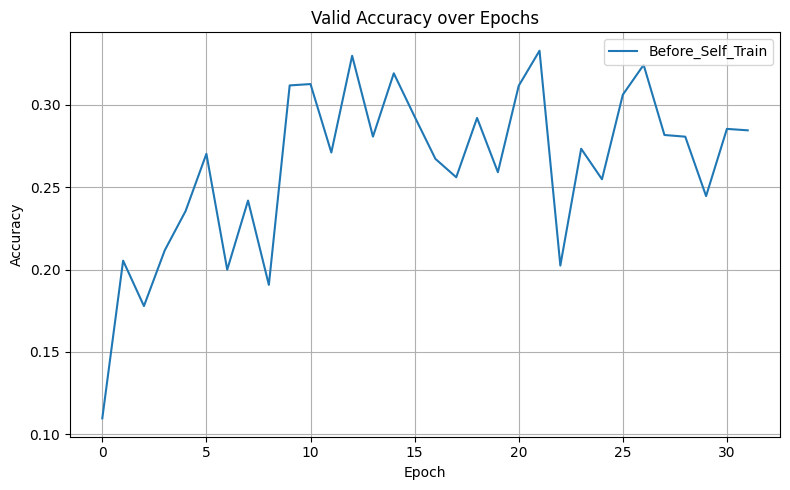

In [57]:
plot_results(results_dict, split="valid")

## Self Training

In [54]:
# doc_emb: (N, d_doc) torch.Tensor
# label_matrix: (N, C) numpy or torch (multi-label 0/1)
# class_emb: (C, d_cls) torch.Tensor
def train_one_round(doc_emb, label_matrix, class_emb,
                    epochs=30, batch_size=32,
                    val_ratio=0.2, patience=5,
                    lr=1e-3, hidden_dim=256, device=device, rnd=0):

    # 라벨을 torch.Tensor로 통일
    if isinstance(label_matrix, torch.Tensor):
        Y = label_matrix.float()
    else:
        Y = torch.tensor(label_matrix, dtype=torch.float32)

    # Dataset & split (train/val)
    dataset = DocDataset(doc_emb=doc_emb, label_matrix=Y)
    num_total = len(dataset)
    val_size = int(num_total * val_ratio)
    train_size = num_total - val_size

    g = torch.Generator().manual_seed(42)
    train_split, val_split = random_split(dataset, [train_size, val_size], generator=g)

    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_split,   batch_size=batch_size, shuffle=False, drop_last=False)

    # 모델 / 옵티마이저 / 손실
    doc_dim = doc_emb.size(1)
    model = DualEncoderClassifier(doc_dim, class_emb, hidden_dim=hidden_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    best_state = copy.deepcopy(model.state_dict())
    best_score = 0.0      # val_result["accuracy"] 기준 (Jaccard)
    wait = 0

    train_losses, val_acc_list = [], []

    for epoch in range(1, epochs + 1):
        # --- Training phase ---
        model.train()
        total_loss = 0.0

        for batch in tqdm(train_loader, desc=f"[Round train] Epoch {epoch}"):
            X = batch["X"].to(device)   # (B, d_doc)
            y = batch["y"].to(device)   # (B, C)

            logits = model(X)           # (B, C)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / max(1, len(train_loader))
        print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

        # --- Validation evaluation ---
        val_result = evaluate(model, val_loader, device=device)
        val_acc = float(val_result.get("accuracy", 0.0))  # Jaccard
        print_eval_result(val_result, stage="validation")
        val_acc_list.append(val_acc)
        print()

        # --- Early Stopping (val_acc 기준) ---
        if val_acc > best_score:
            best_score = val_acc
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"No improvement for {wait} epochs. Early stopping.")
                break

    results_dict['valid'][f'Self_Train_Round_{rnd}'] = val_acc_list[:]

    # best 모델 로드
    model.load_state_dict(best_state)
    return model


In [55]:
def self_training(doc_emb, Y_init, class_emb,
                  num_rounds=3, pos_thresh=0.8,
                  epochs=30, batch_size=32,
                  val_ratio=0.2, patience=5,
                  lr=1e-3, hidden_dim=256, device=device):

    # Y_init: (N, C) numpy or torch
    if isinstance(Y_init, torch.Tensor):
        Y_cur = Y_init.clone().detach().cpu().numpy()
    else:
        Y_cur = np.array(Y_init, dtype=np.float32)

    doc_emb = doc_emb.to(device)
    class_emb = class_emb.to(device)

    final_model = None

    for rnd in range(1, num_rounds + 1):
        print(f"\n===== Self-Training Round {rnd}/{num_rounds} =====")

        # 1) 현재 Y_cur로 한 라운드 학습
        model = train_one_round(
            doc_emb=doc_emb,
            label_matrix=Y_cur,
            class_emb=class_emb,
            epochs=epochs,
            batch_size=batch_size,
            val_ratio=val_ratio,
            patience=patience,
            lr=lr,
            hidden_dim=hidden_dim,
            device=device, rnd=rnd
        )

        final_model = model  # 마지막 round 모델을 반환할 예정

        # 2) 전체 문서에 대해 확률 예측
        probs = predict_proba_from_emb(model, doc_emb, batch_size=batch_size, device=device)  # (N, C)
        probs_np = probs.cpu().numpy()

        # 3) pseudo label 업데이트
        #    - 기존 Y_cur == 1 은 그대로 유지
        #    - Y_cur == 0 인 곳 중, probs >= pos_thresh 인 곳을 1로 승격
        mask_pos = (Y_cur == 0) & (probs_np >= pos_thresh)
        newly_added = mask_pos.sum()
        Y_cur[mask_pos] = 1.0

        print(f"[Round {rnd}] Newly added positive pseudo-labels: {int(newly_added)}")

    # 루프가 끝나면 마지막 round의 model과 최종 pseudo-label 행렬 반환
    Y_final = torch.tensor(Y_cur, dtype=torch.float32)
    return final_model, Y_final


In [58]:
# doc_emb: (N, d_doc)  torch.Tensor, encode_texts() 결과
# Y_init:  (N, C)      numpy or torch, TF-IDF silver (multi-label 0/1)
# class_emb: (C, d_cls) torch.Tensor, BERT + NodeGCN 결과

num_rounds = 3
pos_thresh = 0.8  # pseudo-label 승격 기준 (조정 가능)

final_model, Y_final = self_training(
    doc_emb=train_emb,
    Y_init=silver_label_matrix,
    class_emb=class_emb,
    num_rounds=3,
    pos_thresh=0.8,
    epochs=30,
    batch_size=32,
    val_ratio=0.2,
    patience=5,
    lr=1e-3,
    hidden_dim=256,
    device=device,
)


===== Self-Training Round 1/3 =====


[Round train] Epoch 1: 100%|██████████| 738/738 [00:06<00:00, 119.85it/s]


[Epoch 1] Train Loss: 0.0289
[VALIDATION] Acc: 0.1441 | F1-macro: 0.0019



[Round train] Epoch 2: 100%|██████████| 738/738 [00:06<00:00, 120.88it/s]


[Epoch 2] Train Loss: 0.0219
[VALIDATION] Acc: 0.2204 | F1-macro: 0.0033



[Round train] Epoch 3: 100%|██████████| 738/738 [00:06<00:00, 118.54it/s]


[Epoch 3] Train Loss: 0.0203
[VALIDATION] Acc: 0.2827 | F1-macro: 0.0041



[Round train] Epoch 4: 100%|██████████| 738/738 [00:06<00:00, 117.29it/s]


[Epoch 4] Train Loss: 0.0193
[VALIDATION] Acc: 0.2647 | F1-macro: 0.0044



[Round train] Epoch 5: 100%|██████████| 738/738 [00:06<00:00, 117.62it/s]


[Epoch 5] Train Loss: 0.0187
[VALIDATION] Acc: 0.1788 | F1-macro: 0.0063



[Round train] Epoch 6: 100%|██████████| 738/738 [00:06<00:00, 118.20it/s]


[Epoch 6] Train Loss: 0.0182
[VALIDATION] Acc: 0.2481 | F1-macro: 0.0086



[Round train] Epoch 7: 100%|██████████| 738/738 [00:06<00:00, 119.40it/s]


[Epoch 7] Train Loss: 0.0178
[VALIDATION] Acc: 0.3414 | F1-macro: 0.0101



[Round train] Epoch 8: 100%|██████████| 738/738 [00:06<00:00, 119.21it/s]


[Epoch 8] Train Loss: 0.0175
[VALIDATION] Acc: 0.2911 | F1-macro: 0.0118



[Round train] Epoch 9: 100%|██████████| 738/738 [00:06<00:00, 120.42it/s]


[Epoch 9] Train Loss: 0.0172
[VALIDATION] Acc: 0.2592 | F1-macro: 0.0161



[Round train] Epoch 10: 100%|██████████| 738/738 [00:06<00:00, 119.58it/s]


[Epoch 10] Train Loss: 0.0170
[VALIDATION] Acc: 0.3188 | F1-macro: 0.0139



[Round train] Epoch 11: 100%|██████████| 738/738 [00:06<00:00, 120.35it/s]


[Epoch 11] Train Loss: 0.0168
[VALIDATION] Acc: 0.3142 | F1-macro: 0.0143



[Round train] Epoch 12: 100%|██████████| 738/738 [00:06<00:00, 119.93it/s]


[Epoch 12] Train Loss: 0.0166
[VALIDATION] Acc: 0.2095 | F1-macro: 0.0137

No improvement for 5 epochs. Early stopping.
[Round 1] Newly added positive pseudo-labels: 8425

===== Self-Training Round 2/3 =====


[Round train] Epoch 1: 100%|██████████| 738/738 [00:06<00:00, 117.34it/s]


[Epoch 1] Train Loss: 0.0293
[VALIDATION] Acc: 0.2857 | F1-macro: 0.0030



[Round train] Epoch 2: 100%|██████████| 738/738 [00:06<00:00, 116.72it/s]


[Epoch 2] Train Loss: 0.0215
[VALIDATION] Acc: 0.3112 | F1-macro: 0.0042



[Round train] Epoch 3: 100%|██████████| 738/738 [00:06<00:00, 118.97it/s]


[Epoch 3] Train Loss: 0.0200
[VALIDATION] Acc: 0.3501 | F1-macro: 0.0044



[Round train] Epoch 4: 100%|██████████| 738/738 [00:06<00:00, 118.64it/s]


[Epoch 4] Train Loss: 0.0190
[VALIDATION] Acc: 0.3246 | F1-macro: 0.0055



[Round train] Epoch 5: 100%|██████████| 738/738 [00:06<00:00, 119.19it/s]


[Epoch 5] Train Loss: 0.0184
[VALIDATION] Acc: 0.3849 | F1-macro: 0.0070



[Round train] Epoch 6: 100%|██████████| 738/738 [00:06<00:00, 118.76it/s]


[Epoch 6] Train Loss: 0.0179
[VALIDATION] Acc: 0.3187 | F1-macro: 0.0065



[Round train] Epoch 7: 100%|██████████| 738/738 [00:06<00:00, 119.41it/s]


[Epoch 7] Train Loss: 0.0176
[VALIDATION] Acc: 0.3821 | F1-macro: 0.0102



[Round train] Epoch 8: 100%|██████████| 738/738 [00:06<00:00, 118.70it/s]


[Epoch 8] Train Loss: 0.0173
[VALIDATION] Acc: 0.2570 | F1-macro: 0.0095



[Round train] Epoch 9: 100%|██████████| 738/738 [00:06<00:00, 119.48it/s]


[Epoch 9] Train Loss: 0.0170
[VALIDATION] Acc: 0.3964 | F1-macro: 0.0131



[Round train] Epoch 10: 100%|██████████| 738/738 [00:06<00:00, 119.58it/s]


[Epoch 10] Train Loss: 0.0168
[VALIDATION] Acc: 0.3554 | F1-macro: 0.0154



[Round train] Epoch 11: 100%|██████████| 738/738 [00:06<00:00, 119.72it/s]


[Epoch 11] Train Loss: 0.0166
[VALIDATION] Acc: 0.3785 | F1-macro: 0.0121



[Round train] Epoch 12: 100%|██████████| 738/738 [00:06<00:00, 119.88it/s]


[Epoch 12] Train Loss: 0.0164
[VALIDATION] Acc: 0.3629 | F1-macro: 0.0165



[Round train] Epoch 13: 100%|██████████| 738/738 [00:06<00:00, 119.71it/s]


[Epoch 13] Train Loss: 0.0163
[VALIDATION] Acc: 0.4067 | F1-macro: 0.0180



[Round train] Epoch 14: 100%|██████████| 738/738 [00:06<00:00, 120.63it/s]


[Epoch 14] Train Loss: 0.0161
[VALIDATION] Acc: 0.3436 | F1-macro: 0.0162



[Round train] Epoch 15: 100%|██████████| 738/738 [00:06<00:00, 119.66it/s]


[Epoch 15] Train Loss: 0.0160
[VALIDATION] Acc: 0.3544 | F1-macro: 0.0154



[Round train] Epoch 16: 100%|██████████| 738/738 [00:06<00:00, 121.19it/s]


[Epoch 16] Train Loss: 0.0159
[VALIDATION] Acc: 0.4011 | F1-macro: 0.0207



[Round train] Epoch 17: 100%|██████████| 738/738 [00:06<00:00, 120.13it/s]


[Epoch 17] Train Loss: 0.0158
[VALIDATION] Acc: 0.3913 | F1-macro: 0.0181



[Round train] Epoch 18: 100%|██████████| 738/738 [00:06<00:00, 120.13it/s]


[Epoch 18] Train Loss: 0.0157
[VALIDATION] Acc: 0.3535 | F1-macro: 0.0181

No improvement for 5 epochs. Early stopping.
[Round 2] Newly added positive pseudo-labels: 4180

===== Self-Training Round 3/3 =====


[Round train] Epoch 1: 100%|██████████| 738/738 [00:06<00:00, 119.84it/s]


[Epoch 1] Train Loss: 0.0292
[VALIDATION] Acc: 0.3804 | F1-macro: 0.0043



[Round train] Epoch 2: 100%|██████████| 738/738 [00:06<00:00, 118.85it/s]


[Epoch 2] Train Loss: 0.0210
[VALIDATION] Acc: 0.3687 | F1-macro: 0.0046



[Round train] Epoch 3: 100%|██████████| 738/738 [00:06<00:00, 119.31it/s]


[Epoch 3] Train Loss: 0.0195
[VALIDATION] Acc: 0.3656 | F1-macro: 0.0046



[Round train] Epoch 4: 100%|██████████| 738/738 [00:06<00:00, 119.00it/s]


[Epoch 4] Train Loss: 0.0185
[VALIDATION] Acc: 0.4083 | F1-macro: 0.0059



[Round train] Epoch 5: 100%|██████████| 738/738 [00:06<00:00, 118.93it/s]


[Epoch 5] Train Loss: 0.0178
[VALIDATION] Acc: 0.3838 | F1-macro: 0.0078



[Round train] Epoch 6: 100%|██████████| 738/738 [00:06<00:00, 119.03it/s]


[Epoch 6] Train Loss: 0.0174
[VALIDATION] Acc: 0.4151 | F1-macro: 0.0111



[Round train] Epoch 7: 100%|██████████| 738/738 [00:06<00:00, 118.88it/s]


[Epoch 7] Train Loss: 0.0170
[VALIDATION] Acc: 0.4092 | F1-macro: 0.0111



[Round train] Epoch 8: 100%|██████████| 738/738 [00:06<00:00, 119.28it/s]


[Epoch 8] Train Loss: 0.0167
[VALIDATION] Acc: 0.3871 | F1-macro: 0.0108



[Round train] Epoch 9: 100%|██████████| 738/738 [00:06<00:00, 118.89it/s]


[Epoch 9] Train Loss: 0.0165
[VALIDATION] Acc: 0.4292 | F1-macro: 0.0163



[Round train] Epoch 10: 100%|██████████| 738/738 [00:06<00:00, 119.62it/s]


[Epoch 10] Train Loss: 0.0162
[VALIDATION] Acc: 0.4226 | F1-macro: 0.0156



[Round train] Epoch 11: 100%|██████████| 738/738 [00:06<00:00, 119.10it/s]


[Epoch 11] Train Loss: 0.0161
[VALIDATION] Acc: 0.4233 | F1-macro: 0.0173



[Round train] Epoch 12: 100%|██████████| 738/738 [00:06<00:00, 119.99it/s]


[Epoch 12] Train Loss: 0.0159
[VALIDATION] Acc: 0.4298 | F1-macro: 0.0187



[Round train] Epoch 13: 100%|██████████| 738/738 [00:06<00:00, 119.12it/s]


[Epoch 13] Train Loss: 0.0158
[VALIDATION] Acc: 0.4308 | F1-macro: 0.0218



[Round train] Epoch 14: 100%|██████████| 738/738 [00:06<00:00, 119.87it/s]


[Epoch 14] Train Loss: 0.0157
[VALIDATION] Acc: 0.4542 | F1-macro: 0.0234



[Round train] Epoch 15: 100%|██████████| 738/738 [00:06<00:00, 120.03it/s]


[Epoch 15] Train Loss: 0.0155
[VALIDATION] Acc: 0.4459 | F1-macro: 0.0225



[Round train] Epoch 16: 100%|██████████| 738/738 [00:07<00:00, 103.86it/s]


[Epoch 16] Train Loss: 0.0154
[VALIDATION] Acc: 0.4303 | F1-macro: 0.0212



[Round train] Epoch 17: 100%|██████████| 738/738 [00:06<00:00, 120.27it/s]


[Epoch 17] Train Loss: 0.0153
[VALIDATION] Acc: 0.4489 | F1-macro: 0.0271



[Round train] Epoch 18: 100%|██████████| 738/738 [00:06<00:00, 119.43it/s]


[Epoch 18] Train Loss: 0.0152
[VALIDATION] Acc: 0.4233 | F1-macro: 0.0190



[Round train] Epoch 19: 100%|██████████| 738/738 [00:06<00:00, 120.52it/s]


[Epoch 19] Train Loss: 0.0151
[VALIDATION] Acc: 0.4291 | F1-macro: 0.0305

No improvement for 5 epochs. Early stopping.
[Round 3] Newly added positive pseudo-labels: 4360


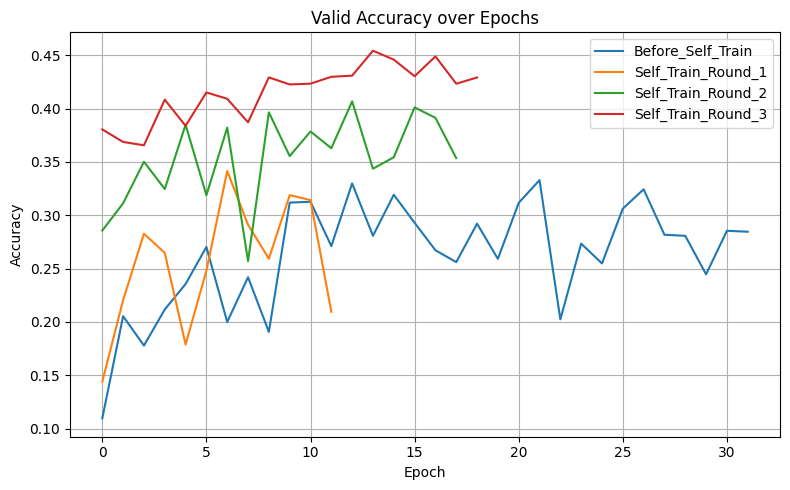

In [59]:
plot_results(results_dict, split="valid")

In [63]:
def predict_proba_from_emb(model, emb, batch_size=64, device="cuda"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for i in range(0, emb.size(0), batch_size):
            batch_emb = emb[i:i+batch_size].to(device)  # (B, d_doc)
            logits = model(batch_emb)                  # (B, C)
            probs  = torch.sigmoid(logits)             # (B, C)
            all_probs.append(probs.cpu())
    return torch.cat(all_probs, dim=0)  # (N, C)

In [60]:
model.load_state_dict(best_model_state)  # 학습 끝난 최적 파라미터

model.eval()
probs_test = predict_proba_from_emb(model, test_emb, batch_size=64, device=device)

In [61]:
k = 3
threshold = 0.2

# 1) 문서별 top-k (값 / 인덱스)
topk_vals, topk_idx = torch.topk(probs_test, k=k, dim=1)  # (N_test, k)

selected_indices_per_doc = []
selected_scores_per_doc = []

for i in range(probs_test.size(0)):  # N_test
    vals_i = topk_vals[i]      # (k,)
    idx_i  = topk_idx[i]       # (k,)

    # 2) threshold 통과하는 것만 선택
    mask = vals_i >= threshold
    valid_idxs = idx_i[mask]
    valid_vals = vals_i[mask]

    if valid_idxs.numel() == 0:
        # 3) threshold 넘는 게 하나도 없으면 → 제일 높은 거 하나만
        best_idx = idx_i[0].unsqueeze(0)   # 맨 첫 번째(top-1)
        best_val = vals_i[0].unsqueeze(0)
        selected_indices_per_doc.append(best_idx.tolist())
        selected_scores_per_doc.append(best_val.tolist())
    else:
        selected_indices_per_doc.append(valid_idxs.tolist())
        selected_scores_per_doc.append(valid_vals.tolist())

print(selected_indices_per_doc)
print(selected_scores_per_doc)

[[3, 4, 128], [18, 3, 200], [3, 4, 128], [0, 497, 128], [67, 3, 45], [206, 8, 249], [397], [100, 200, 108], [49, 3], [100, 200], [340, 359, 205], [405, 83, 135], [3, 4, 128], [409], [3, 4, 128], [3, 128, 4], [3, 4, 128], [3, 128, 4], [3, 4, 128], [220, 221], [3, 4, 128], [3, 4, 128], [3], [340, 0], [3, 29, 4], [3, 128, 4], [3, 100, 4], [3, 4, 128], [18, 3, 200], [3, 4, 128], [3, 4, 128], [3, 4, 128], [368, 40, 296], [128, 3, 4], [220, 3, 25], [3, 128, 301], [3, 128, 4], [3, 4, 128], [3, 4, 128], [3, 128, 4], [3, 128, 4], [3, 301, 4], [3, 4, 128], [128, 3, 4], [3, 4, 12], [128, 3, 4], [200, 3, 128], [3, 128, 4], [3, 4, 128], [405, 128, 3], [3, 128, 129], [3, 4, 128], [220, 3, 67], [3, 4, 128], [3, 301, 4], [3, 4, 128], [455], [3, 128, 4], [3, 4, 128], [3, 4, 128], [3, 4, 128], [64, 524, 323], [271, 346], [3, 4, 128], [3, 4, 128], [3, 128, 4], [128, 3, 4], [3, 4, 128], [18, 200, 3], [3, 128, 4], [3, 4, 323], [524, 323, 64], [3, 128, 100], [3, 128, 4], [220, 221, 3], [100, 340, 0], [3, 4,

In [ ]:
import os, csv
os.makedirs("outputs", exist_ok=True)

SUBMISSION_PATH = "outputs/gcn-mlp-self.csv"

test_ids = list(range(len(selected_indices_per_doc)))

def format_labels(label_indices):
    """
    label_indices: [int, int, ...]
    return: "라벨1, 라벨2, 라벨3" 형태의 문자열
    """
    if len(label_indices) == 0:
        return ""
    return ",".join(str(idx) for idx in label_indices)

# 각 문서별로 "라벨1, 라벨2, 라벨3" 형태의 문자열 만들기
labels_str_list = [format_labels(idxs) for idxs in selected_indices_per_doc]

# id / labels DataFrame 생성
pred_df = pd.DataFrame({
    "id": test_ids,
    "labels": labels_str_list,
})

pred_df.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8-sig")

print(f"Saved predictions to {SUBMISSION_PATH}")

Saved predictions to /content/drive/MyDrive/BDA Project/outputs/gcn-mlp-self.csv
